In [7]:
import pandas as pd
import shutil
import os
import cv2
import numpy as np

In [2]:
base_dir = 'database/dataset'
categorias = ['normal','benigno', 'maligno']

In [4]:
def read_imageResize_with_labels(dir='..\database\dataset',target_size = (224,224)):
    """
    Lee imágenes de un directorio, las redimensiona a 224x224 píxeles y las etiqueta según 
    la subcarpeta en la que se encuentran. Las imágenes son procesadas en escala de grises.

    Parámetros:
    dir (str): La ruta del directorio principal que contiene las subcarpetas con las imágenes. 
               Las subcarpetas deben llamarse 'normal', 'benigno' y 'maligno' para que 
               las etiquetas se asignen correctamente. Las subcarpetas no definidas 
               recibirán una etiqueta de -1.

    Retorno:
    tuple: Una tupla que contiene dos elementos:
        - np.array: Un array de NumPy con las imágenes redimensionadas.
        - list: Una lista de etiquetas correspondientes a las imágenes.
    """
    labels = []
    imgs = []
    for subfolder in os.listdir(dir):
        
        subfolder_path = os.path.join(dir,subfolder)
        for name_image in os.listdir(subfolder_path):
            bandera = False    

            # Obtener la etiqueta desde el nombre de la subcarpeta
            if subfolder == 'normal':
                bandera = True
                labels.append(0)
            elif subfolder == 'benigno':
                bandera = True
                labels.append(1)
            elif subfolder == 'maligno':
                bandera = True
                labels.append(2)

            if bandera:    
           
                # Obtenemos la ruta de la imagen
                image_path = os.path.join(subfolder_path,name_image)
                
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                # Resize the image
                image = cv2.resize(image, target_size, interpolation=cv2.INTER_CUBIC)
            
                imgs.append(image)
    
    return  np.array(imgs), labels

In [8]:
# Leer las imagenes originales con sus etiquetas

imgs, labels = read_imageResize_with_labels(dir='database/dataset')

In [9]:
# Comprobar la cantidad
print(imgs.shape)
print(len(labels))

(3608, 224, 224)
3608


In [10]:
# Verificar normalizacion
unicos = np.unique(imgs[0])
max(unicos)

255

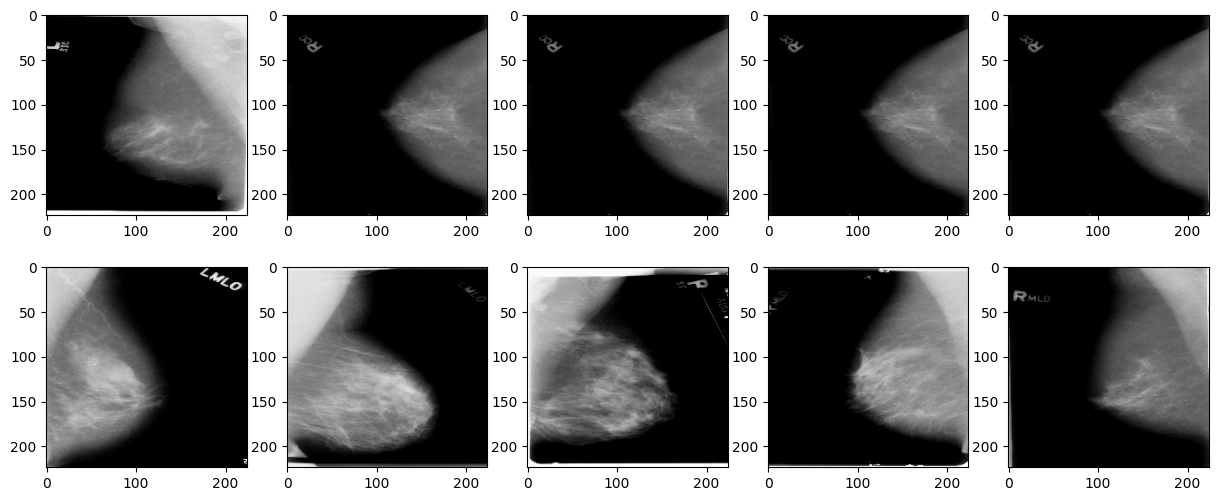

In [12]:
import matplotlib.pyplot as plt
def show_imgs(imgs):
    '''
    Muestra una lista de imágenes en una matriz de 2 filas y 5 columnas utilizando Matplotlib.

    Parametros:
    - imgs: Una lista de matrices numpy representando las imágenes a mostrar.
    
    Esta función crea una figura con subtramas dispuestas en una matriz de 2x5.
    Recorre la lista de imágenes y las muestra en estas subtramas. Si hay menos de
    10 imágenes en la lista, los espacios restantes en la matriz quedan en blanco.
    '''
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    for i in range(2):
        for j in range(5):
            if i*5 + j < len(imgs):
                axes[i, j].imshow(imgs[i*5 + j],cmap = 'gray')
                #axes[i, j].axis('off')

    plt.show()
    
show_imgs(imgs)

Dado la comparación de las imágenes con filtro gaussiano y las originales del dataset, se decide no aplicar este filtro ya que el suavisado produce que las imágenes de vean borrosas, a diferencias de lo hecho con CLAHE que aumente el contraste de la imagen

In [13]:
unique_labels, unique_counts = np.unique(labels, return_counts=True)

# Crea un diccionario con las etiquetas y sus conteos
labels_histogram = dict(zip(unique_labels, unique_counts))

print(labels_histogram)

{0: 207, 1: 1995, 2: 1406}


In [15]:
output_dir = 'database/datasetV2'

# Definir un diccionario para mapear las etiquetas numéricas a nombres de carpetas
label_dict = {0: 'normal', 1: 'benigno', 2: 'maligno'}

# Crear las carpetas si no existen
for label_name in label_dict.values():
    os.makedirs(os.path.join(output_dir, label_name), exist_ok=True)

# Recorrer los arreglos de imágenes y etiquetas
for idx, (img, label) in enumerate(zip(imgs, labels)):
    # Obtener el nombre de la carpeta basado en la etiqueta
    label_name = label_dict.get(label)
    
    # Crear un nombre de archivo único para cada imagen
    img_name = f'image_{idx}.jpg'
    
    # Definir la carpeta de destino
    dest_folder = os.path.join(output_dir, label_name)
    
    # Guardar la imagen en la carpeta correspondiente
    img_path = os.path.join(dest_folder, img_name)
    
    # Guardar la imagen usando OpenCV (cv2.imwrite)
    cv2.imwrite(img_path, img)

print("Imágenes organizadas y guardadas correctamente.")

Imágenes organizadas y guardadas correctamente.


In [23]:
labels = np.array(labels)
print(f"Tamaño de imgs: {imgs.shape}")
print(f"Tamaño de labels: {labels.shape}")


Tamaño de imgs: (3608, 224, 224)
Tamaño de labels: (3608,)


In [24]:
print(f"Imágenes con etiqueta 1 (benigno): {np.sum(labels == 1)}")

Imágenes con etiqueta 1 (benigno): 1995


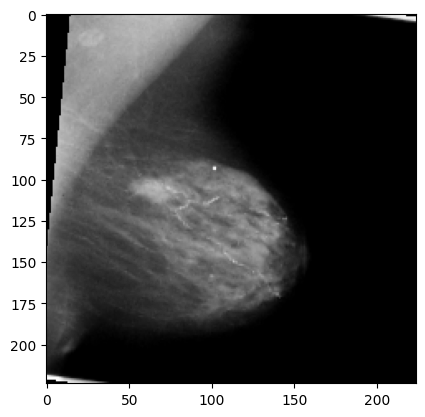

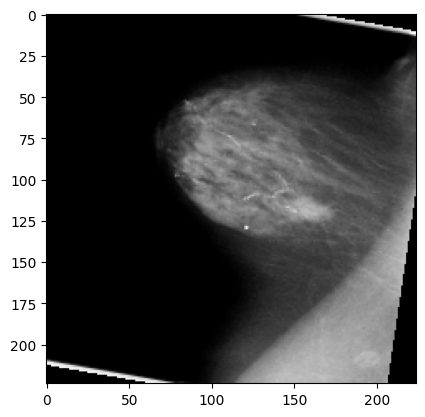

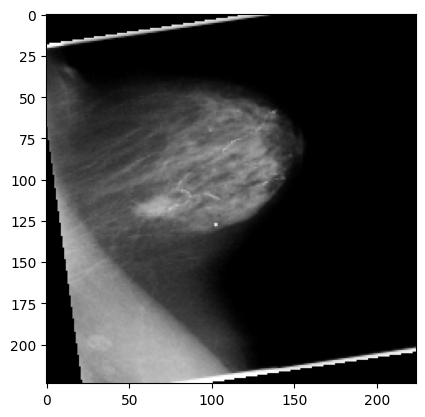

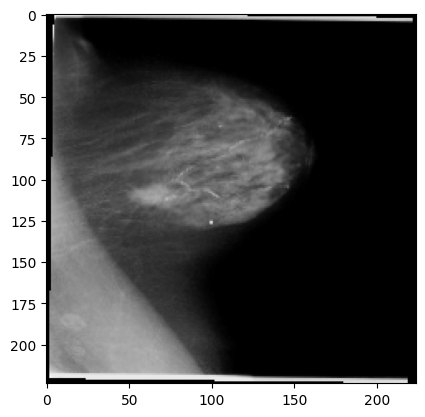

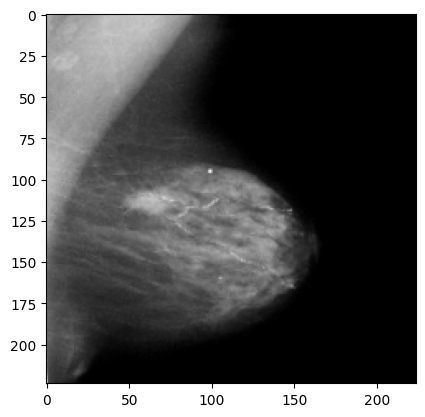

In [47]:
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Definir el Data Generator con transformaciones
datagen = ImageDataGenerator(
 # Eliminar cizallamiento
    rotation_range=10,
    zoom_range=0.1,  # Zoom muy pequeño
    horizontal_flip=True,
    vertical_flip=True,  # Volteo horizontal
    fill_mode='constant',  # Usar relleno constante para el área vacía
    cval=0  # Rellenar con color negro (0 en escala de grises)
)

# Filtrar las imágenes benignas (clase 1)
benign_images = imgs[labels == 2]  # Filtrar las imágenes de la clase 1 (benigno)

# Asegúrate de que tienes imágenes
if benign_images.shape[0] > 0:
    # Seleccionar la primera imagen y expandir la dimensión del canal
    img = benign_images[0]  # Selecciona una imagen de ejemplo
    img = np.expand_dims(img, axis=-1)  # Expande las dimensiones para que sea (224, 224, 1)

    # Expande también el batch_size para que sea (1, 224, 224, 1)
    img = np.expand_dims(img, axis=0)  # Ahora es (1, 224, 224, 1)

    # Crear un generador de augmentación
    aug_iter = datagen.flow(img, batch_size=1)
    
    # Mostrar las primeras imágenes augmentadas generadas
    for i in range(5):  # Generar 5 imágenes augmentadas como prueba
        aug_img = next(aug_iter)[0].astype('uint8')  # Obtener una imagen augmentada
        aug_img = aug_img.squeeze(-1)  # Eliminar la dimensión del canal para mostrar con plt.imshow
        plt.imshow(aug_img, cmap='gray')
        plt.show()
else:
    print("No se encontraron imágenes con la etiqueta 2.")
